In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df_n_ligacoes = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/Ligações por Municipio.csv')
df_n_ligacoes = df_n_ligacoes.rename(columns={'COUNT(1)': 'NUM_LIGACOES'})
df_n_ligacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CD_MUNICIPIO  203 non-null    int64
 1   NUM_LIGACOES  203 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB


In [12]:
df_vistorias = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/V_VISTORIAS_EXECUTADAS_202510141605.csv')
df_vistorias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105 entries, 0 to 6104
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   CD_MUNICIPIO                 6105 non-null   int64 
 1   SITUACAO_VISTORIA            6105 non-null   int64 
 2   SITUACAO_VISTORIA_DESCRICAO  6105 non-null   object
 3   DATA_EXECUCAO                6105 non-null   object
dtypes: int64(2), object(2)
memory usage: 190.9+ KB


In [13]:
df_municipios = pd.read_csv('/home/breno/projects/sobre-rodas/data/raw/ORGAO_EMPRESA_202510141615.csv')
df_municipios = df_municipios.rename(columns={'CD_ORGAO_EMPRESA': 'CD_MUNICIPIO', 'NM_ORGAO_EMPRESA': 'NM_MUNICIPIO'})
df_municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CD_MUNICIPIO  473 non-null    int64 
 1   NM_MUNICIPIO  473 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.5+ KB


In [16]:
# 1. Calcular NUM_VISTORIAS: Agrupa df_vistorias por município e conta o número de vistorias.
df_num_vistorias = (
    df_vistorias.groupby('CD_MUNICIPIO')
    .size()
    .reset_index(name='NUM_VISTORIAS')
)

# 2. Renomear coluna em df_n_ligacoes: Altera 'NOME_LIGACOES' para 'NUM_LIGACOES'.
df_n_ligacoes_renomeado = df_n_ligacoes.rename(columns={'NOME_LIGACOES': 'NUM_LIGACOES'})

# 3. Merge dos DataFrames: Junta df_municipios, df_n_ligacoes e df_num_vistorias
df_novo = df_municipios.merge(
    df_n_ligacoes_renomeado[['CD_MUNICIPIO', 'NUM_LIGACOES']],
    on='CD_MUNICIPIO',
    how='left'
)
df_novo = df_novo.merge(
    df_num_vistorias,
    on='CD_MUNICIPIO',
    how='left'
)

# 4. Tratar valores ausentes (NaN) com 0 para as colunas de cálculo
df_novo['NUM_LIGACOES'] = df_novo['NUM_LIGACOES'].fillna(0).astype(int)
df_novo['NUM_VISTORIAS'] = df_novo['NUM_VISTORIAS'].fillna(0).astype(int)

# 5. FILTRAGEM: Manter apenas os municípios onde NUM_VISTORIAS é maior que 0.
df_novo = df_novo[df_novo['NUM_VISTORIAS'] > 0]

# 6. Calcular VISTORIAS_POR_LIGACAOES, tratando a divisão por zero.
df_novo['VISTORIAS_POR_LIGACAOES'] = np.where(
    df_novo['NUM_LIGACOES'] != 0,
    df_novo['NUM_VISTORIAS'] / df_novo['NUM_LIGACOES'],
    0.0
)

# 7. Selecionar e ordenar as colunas finais
df_final = df_novo[['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NUM_LIGACOES', 'NUM_VISTORIAS', 'VISTORIAS_POR_LIGACAOES']]

df_final

,CD_MUNICIPIO,NM_MUNICIPIO,NUM_LIGACOES,NUM_VISTORIAS,VISTORIAS_POR_LIGACAOES
247,524,MONDAÍ,2800,1657,0.591786
255,532,AGUA DOCE,1570,324,0.206369
288,571,DESCANSO,2131,1524,0.715157
312,599,ITAIÓPOLIS,5745,7,0.001218
325,615,LUIZ ALVES,1705,2,0.001173
327,617,MAJOR VIEIRA,1352,598,0.442308
331,621,MATOS COSTA,667,130,0.194903
397,701,OTACÍLIO COSTA,5993,1,0.000167
417,734,IPORÃ DO OESTE,2480,1378,0.555645
424,748,BELMONTE,593,6,0.010118


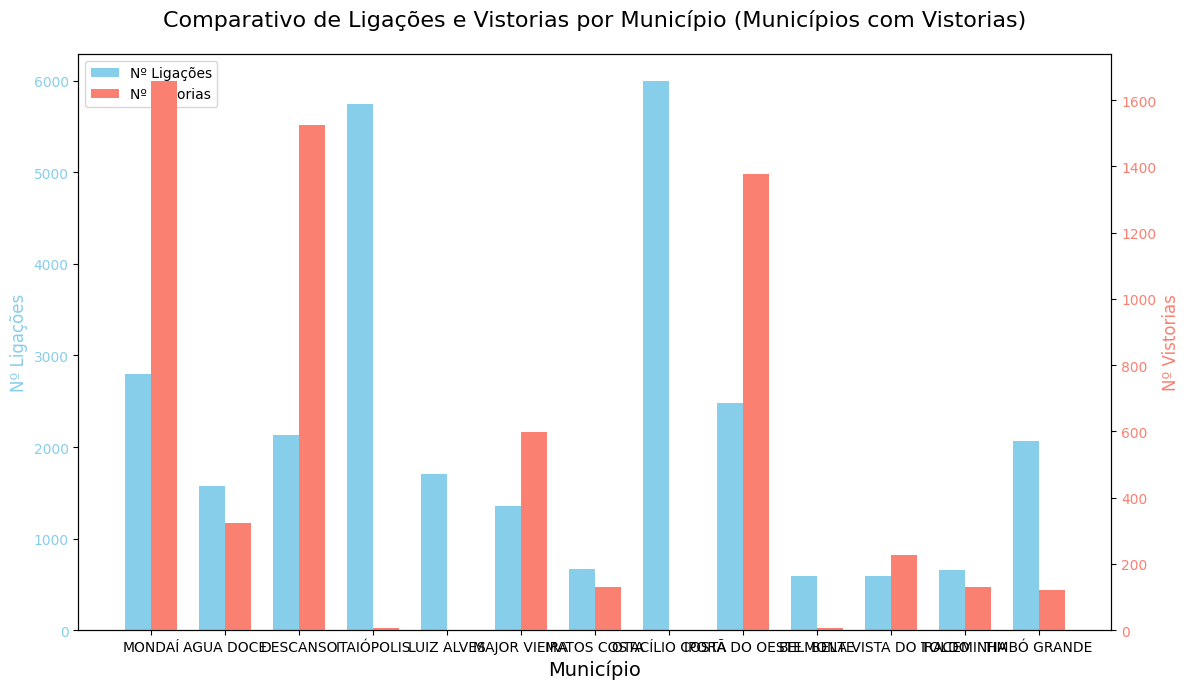

In [18]:
# --- Preparação dos Dados para o Gráfico ---

labels = df_final['NM_MUNICIPIO']
ligacoes = df_final['NUM_LIGACOES']
vistorias = df_final['NUM_VISTORIAS']

x = np.arange(len(labels))  # Localizações dos rótulos (0, 1, 2, ...)
width = 0.35  # Largura das barras

# --- Código de Plotagem (Gráfico de Barras Agrupadas com Eixo Duplo) ---

# Cria a figura e o eixo principal (ax1)
fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. Plot NUM_LIGACOES no eixo primário (ax1)
rects1 = ax1.bar(x - width/2, ligacoes, width, label='Nº Ligações', color='skyblue')
ax1.set_ylabel('Nº Ligações', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')

# 2. Cria um eixo secundário (ax2) para NUM_VISTORIAS (twinx() faz isso)
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, vistorias, width, label='Nº Vistorias', color='salmon')
ax2.set_ylabel('Nº Vistorias', color='salmon', fontsize=12)
ax2.tick_params(axis='y', labelcolor='salmon')

# 3. Configurações gerais e rótulos
ax1.set_xlabel('Município', fontsize=14)
ax1.set_title('Comparativo de Ligações e Vistorias por Município (Municípios com Vistorias)', fontsize=16, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=0, ha='center', fontsize=10) # Rótulos dos municípios no eixo X

# 4. Combina as legendas de ambos os eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# Ajusta o layout para evitar sobreposição
fig.tight_layout() 

# Mostra o gráfico (ou salva)
plt.show() 
# plt.savefig('ligacoes_vs_vistorias_dual_axis.png')